# Manipulating ONNX Graphs

## The Target

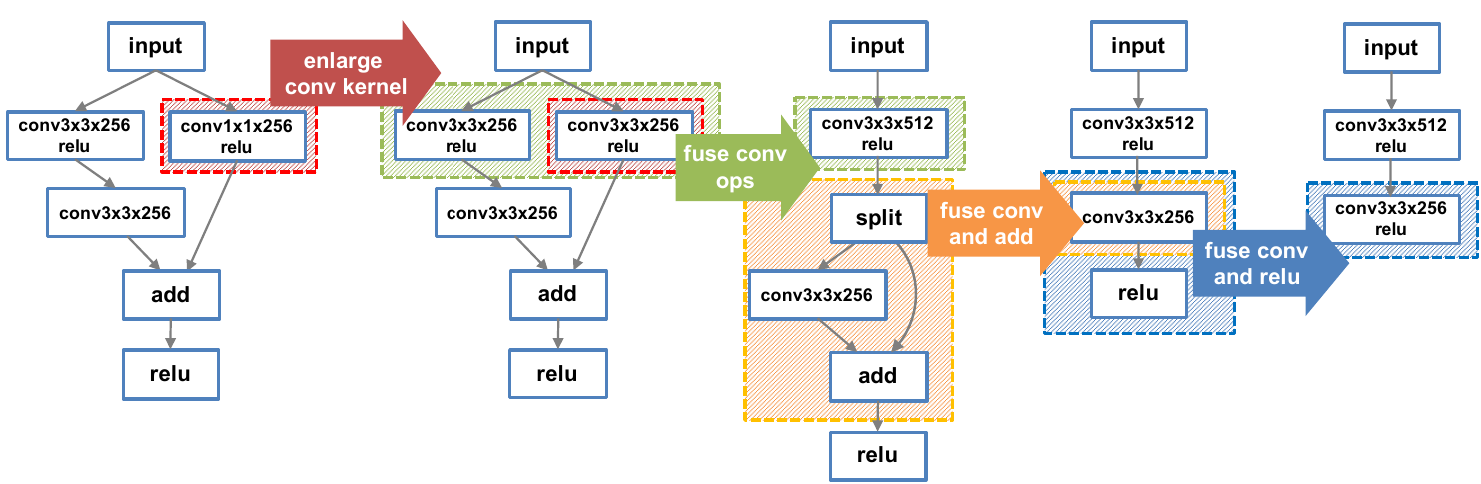

In [87]:
from IPython.display import Image

image_path = "./relaxed_substitution_example.png"
Image(image_path)

## Creating the computational graph in ONNX

We'll define Convolution and ReLU units and then assemble our custom computation graph

In [88]:
import numpy as np
import onnx
from onnx import helper, TensorProto

In [100]:
class ConvLayer:
    def __init__(self, name, c_in, c_out, kernel_shape, pads, weights=None, bias=None):
        self.name = name
        self.c_in = c_in
        self.c_out = c_out
        self.kernel_shape = kernel_shape
        self.pads = pads

        # Initialize weights and bias if not provided
        self.W = weights if weights is not None else np.ones((c_out, c_in, *kernel_shape)).astype(np.float32)
        self.B = bias if bias is not None else np.ones((c_out,)).astype(np.float32)
        
        # Create initializer tensors for weights and bias
        self.W_initializer_tensor_name = f"{self.name}_W"
        self.W_initializer_tensor = self.create_initializer_tensor(self.W_initializer_tensor_name, self.W)

        self.B_initializer_tensor_name = f"{self.name}_B"
        self.B_initializer_tensor = self.create_initializer_tensor(self.B_initializer_tensor_name, self.B)
    
    def create_initializer_tensor(self, name, tensor_array):
        return onnx.helper.make_tensor(
            name=name,
            data_type=onnx.TensorProto.FLOAT,
            dims=tensor_array.shape,
            vals=tensor_array.flatten(),
        )

    def make_node(self, input_name, output_name):
        return helper.make_node(
            name=self.name,
            op_type="Conv",
            inputs=[input_name, self.W_initializer_tensor_name, self.B_initializer_tensor_name],
            outputs=[output_name],
            kernel_shape=self.kernel_shape,
            pads=self.pads,
            strides=[1, 1],
        )

class ReluLayer:
    def __init__(self, name):
        self.name = name
    
    def make_node(self, input_name, output_name):
        return helper.make_node(
            name=self.name,
            op_type="Relu",
            inputs=[input_name],
            outputs=[output_name],
        )

class AddLayer:
    def __init__(self, name):
        self.name = name
    
    def make_node(self, input1_name, input2_name, output_name):
        return helper.make_node(
            name=self.name,
            op_type="Add",
            inputs=[input1_name, input2_name],
            outputs=[output_name],
        )

In [109]:
# Define an input and output tensor with a specific NCHW
N_in = 1
C_in = 256
H_in = 64
W_in = 64
model_input_name = "input"
input_tensor = helper.make_tensor_value_info(model_input_name, TensorProto.FLOAT, [N_in, C_in, H_in, W_in])

N_out = 1
C_out = 256
H_out = 64
W_out = 64
model_output_name = "Output"
output_tensor = onnx.helper.make_tensor_value_info(model_output_name, TensorProto.FLOAT, [N_out, C_out, H_out, W_out])

In [110]:
conv1 = ConvLayer(name="Conv1", c_in=256, c_out=256, kernel_shape=(3, 3), pads=(1, 1, 1, 1))
conv1_node = conv1.make_node(input_name=model_input_name, output_name="Conv1_Out")

relu1 = ReluLayer(name="ReLU1")
relu1_node = relu1.make_node(input_name="Conv1_Out", output_name="ReLU1_Out")

In [111]:
conv2 = ConvLayer(name="Conv2", c_in=256, c_out=256, kernel_shape=(1, 1), pads=(0, 0, 0, 0))
conv2_node = conv2.make_node(input_name=model_input_name, output_name="Conv2_Out")
 
relu2 = ReluLayer(name="ReLU2")
relu2_node = relu2.make_node(input_name="Conv2_Out", output_name="ReLU2_Out")

In [112]:
conv3 = ConvLayer(name="Conv3", c_in=256, c_out=256, kernel_shape=(3, 3), pads=(1, 1, 1, 1))
conv3_node = conv3.make_node(input_name="ReLU1_Out", output_name="Conv3_Out")

In [113]:
add1 = AddLayer(name="Add1")
add1_node = add1.make_node(input1_name="Conv3_Out", input2_name="ReLU2_Out", output_name="Add1_Out")

In [114]:
relu3 = ReluLayer(name="ReLU3")
relu3_node = relu3.make_node(input_name="Add1_Out", output_name=model_output_name)

In [115]:
# Create the graph
graph = helper.make_graph(
    nodes=[conv1_node, relu1_node, conv2_node, relu2_node, conv3_node, add1_node, relu3_node],
    name="Custom_Initial_Graph",
    inputs=[input_tensor],  # Graph input
    outputs=[output_tensor],  # Graph output
    initializer=[
        conv1.W_initializer_tensor, conv1.B_initializer_tensor,
        conv2.W_initializer_tensor, conv2.B_initializer_tensor,
        conv3.W_initializer_tensor, conv3.B_initializer_tensor
    ],
)

In [116]:
# Create and save the model
model = helper.make_model(graph, producer_name="onnx-custom-initial")
model.opset_import[0].version = 13

model = onnx.shape_inference.infer_shapes(model)
onnx.checker.check_model(model)

onnx.save(model, "custom_graph.onnx")

## Substitution - 1: Enlarge convolutional kernel

In [85]:
from onnx import numpy_helper
from typing import List

def enlarge_conv_kernel(onnx_model_path: str, node_to_modify: str, enlarged_kernel_size: List[int], sub_num: int) -> None:
    # Load the model
    model = onnx.load(onnx_model_path)
    graph = model.graph
    
    # Step 1: Find the Conv node and modify its kernel size attribute
    for node in graph.node:
        if node.name == node_to_modify:
            for attribute in node.attribute:
                if attribute.name == 'kernel_shape':
                    print(f"Original kernel shape: {attribute.ints}")
                    attribute.ints[:] = enlarged_kernel_size  # Update kernel shape
                    print(f"Updated kernel shape: {attribute.ints}")
                    break

    # Step 2: Adjust the initializer (weights) corresponding to the Conv layer
    for initializer in graph.initializer:
        if initializer.name == f"{node_to_modify}_W":
            # Convert the initializer to a NumPy array
            weights = numpy_helper.to_array(initializer)
            print(f"Original weight shape: {weights.shape}")

            # Calculate new weight shape based on the enlarged kernel size
            new_weight_shape = (
                weights.shape[0],  # Number of output channels (remains unchanged)
                weights.shape[1],  # Number of input channels (remains unchanged)
                enlarged_kernel_size[0],  # New kernel height
                enlarged_kernel_size[1],  # New kernel width
            )

            # Create new weights with adjusted shape (filled with random values as a placeholder)
            # You may want to handle how these values are initialized
            new_weights = np.ones(new_weight_shape).astype(np.float32)

            # Update the initializer with new weights
            new_initializer = numpy_helper.from_array(new_weights, initializer.name)
            graph.initializer.remove(initializer)  # Remove old initializer
            graph.initializer.append(new_initializer)  # Add updated initializer

            print(f"Updated weight shape: {new_weights.shape}")
            break

    output_model_path = f"substitution{sub_num}_conv_graph.onnx"
    onnx.save(model, output_model_path)
    print(f"Model saved as {output_model_path}")

In [86]:
enlarge_conv_kernel(onnx_model_path="./custom_graph.onnx", node_to_modify="Conv2", enlarged_kernel_size=[3, 3], sub_num=1)

Original kernel shape: [1, 1]
Updated kernel shape: [3, 3]
Original weight shape: (256, 256, 1, 1)
Updated weight shape: (256, 256, 3, 3)
Model saved as substitution1_conv_graph.onnx
